# Fox and Hounds '45 — Project Notebook

This notebook implements the **Fox and Hounds '45** project:

- Game engine & rules (6×6, dark-squares only, fox vs hounds)
- Baseline AIs: Fox_Random AI, Hounds_Random_AI
- Fox shortest path AI (BFS)
- Hounds Minimax AI (depth ≥ 4 with alpha–beta)
- Simulation harness (100 games × 4 conditions)
- Plots/tables + reflections

**Team roles (suggested):**
- A: GameBoard + rendering + tests (Cells 3–6)
- B: Random AIs + harness + CSV (Cells 7, 12, 14)
- C: Fox BFS AI + plots (Cells 8, 13)
- D: Hounds Minimax AI + alpha–beta (Cell 9)

In [166]:
import random
from dataclasses import dataclass, replace
from typing import List, Tuple, Optional


In [167]:
from dataclasses import dataclass, replace
from typing import Tuple

@dataclass(frozen=True)
class State:
    """
    Represents the complete state of the Fox and Hounds game.

    Attributes
    ----------
    fox : Tuple[int, int]
        The (row, column) position of the fox piece.
    hounds : Tuple[Tuple[int, int], ...]
        The positions of all four hounds as (row, column) pairs.
        Stored as a tuple of tuples, and always kept sorted so the
        same board position has a consistent representation.
    to_move : str
        Whose turn it is to move next. Either "fox" or "hounds".
    ply : int
        The number of half-moves taken so far. A half-move is one move
        by either the fox or the hounds.
    """
    fox: Tuple[int, int]
    hounds: Tuple[Tuple[int, int], ...]
    to_move: str
    ply: int = 0  # Defaults to 0 at the start of the game


def initial_state() -> State:
    """
    Creates the initial starting state of the game.

    Returns
    -------
    State
        A new State object where:
        - The fox is placed at FOX_START
        - The hounds are placed at HOUNDS_START (sorted for consistency)
        - The fox always moves first
        - The move counter (ply) starts at 0
    """
    return State(
        fox=FOX_START,
        hounds=tuple(sorted(HOUNDS_START)),  # keep order consistent
        to_move="fox",
        ply=0
    )



In [168]:
# board utility functions

def in_bounds(r: int, c: int) -> bool:
    """
    Check whether a given (row, column) is inside the game board.

    Parameters
    ----------
    r : int
        Row index
    c : int
        Column index

    Returns
    -------
    bool
        True if the coordinates are inside the board, False otherwise.
    """
    return 0 <= r < BOARD_N and 0 <= c < BOARD_N


def is_empty(state: State, cell: Tuple[int, int]) -> bool:
    """
    Check whether a given cell is empty (no fox and no hound).

    Parameters
    ----------
    state : State
        The current game state
    cell : (int, int)
        The (row, column) coordinates of the cell to check

    Returns
    -------
    bool
        True if the cell is empty, False if occupied by the fox or a hound.
    """
    if state.fox == cell:
        return False  # fox is here
    return cell not in state.hounds  # any hound is here

def dark_neighbors(cell: Tuple[int, int], movement_deltas: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
    """
    Get all neighboring dark-square positions reachable from a given cell.

    Parameters
    ----------
    cell : (int, int)
        The (row, column) coordinates of the current piece
    movement_deltas : List[(int, int)]
        A list of (row_offset, column_offset) moves allowed for this piece
        (different for the fox and the hounds)

    Returns
    -------
    List[(int, int)]
        All valid (row, column) neighbors that are:
        - inside the board
        - on a dark square
    """
    current_row, current_col = cell
    valid_neighbors: List[Tuple[int, int]] = []

    # Try each possible movement direction
    for row_offset, col_offset in movement_deltas:
        new_row = current_row + row_offset
        new_col = current_col + col_offset

        # Only keep this neighbor if it's on the board and on a dark square
        if in_bounds(new_row, new_col) and DARK(new_row, new_col):
            valid_neighbors.append((new_row, new_col))

    return valid_neighbors


In [169]:
# legal move generation
# Each move is represented as a tuple:
#   - Fox move:   ("FOX", from_position, to_position)
#   - Hound move: ("HOUND", hound_index, from_position, to_position)

def legal_moves_fox(game_state: State) -> List[Tuple]:
    """
    Generate all legal moves for the fox.

    Parameters
    ----------
    game_state : State
        The current game state

    Returns
    -------
    List[Tuple]
        A list of possible fox moves.
        Each move is represented as ("FOX", from_position, to_position).
    """
    fox_moves: List[Tuple] = []

    # Look at each possible neighbor square the fox could move to
    for target_position in dark_neighbors(game_state.fox, FOX_DELTAS):
        if is_empty(game_state, target_position):
            fox_moves.append(("FOX", game_state.fox, target_position))

    return fox_moves


def legal_moves_hounds(game_state: State) -> List[Tuple]:
    """
    Generate all legal moves for the hounds.

    Parameters
    ----------
    game_state : State
        The current game state

    Returns
    -------
    List[Tuple]
        A list of possible hound moves.
        Each move is represented as ("HOUND", hound_index, from_position, to_position).
    """
    hound_moves: List[Tuple] = []

    # Go through each hound by index
    for hound_index, hound_position in enumerate(game_state.hounds):
        # Look at each possible neighbor square this hound could move to
        for target_position in dark_neighbors(hound_position, HOUND_DELTAS):
            if is_empty(game_state, target_position):
                hound_moves.append(("HOUND", hound_index, hound_position, target_position))

    return hound_moves


In [170]:
# ---------------------------------------------
# Game State Updates and End Conditions
# ---------------------------------------------

def apply_move(game_state: State, move: Tuple) -> State:
    """
    Apply a move to the current game state and return the new state.

    Parameters
    ----------
    game_state : State
        The current game state
    move : Tuple
        A move tuple, which can be either:
        - ("FOX", from_position, to_position)
        - ("HOUND", hound_index, from_position, to_position)

    Returns
    -------
    State
        A new State object with the updated positions and turn.
    """
    if move[0] == "FOX":
        piece_type, from_position, to_position = move

        # Verify that the fox is actually located at the starting position of this move
        assert from_position == game_state.fox, "Fox move mismatch!"

        return replace(
            game_state,
            fox=to_position,
            to_move="hounds",
            ply=game_state.ply + 1
        )

    elif move[0] == "HOUND":
        piece_type, hound_index, from_position, to_position = move

        # Convert hounds tuple to a list so we can update one hound
        hounds_list = list(game_state.hounds)

        # Safety check: make sure the right hound is being moved
        assert hounds_list[hound_index] == from_position, "Hound move mismatch!"

        # Update this hound’s position
        hounds_list[hound_index] = to_position

        return replace(
            game_state,
            hounds=tuple(sorted(hounds_list)),  # sort so state stays consistent
            to_move="fox",
            ply=game_state.ply + 1
        )

    else:
        raise ValueError(f"Unknown piece type: {move[0]}")


def is_terminal(game_state: State) -> Tuple[bool, Optional[str]]:
    """
    Determine whether the game has reached a terminal (end) state.

    Parameters
    ----------
    game_state : State
        The current game state.

    Returns
    -------
    Tuple[bool, Optional[str]]
        A pair (is_over, winner):
        - (True, "fox")     if the fox has reached the goal square
        - (True, "hounds")  if it's the fox's turn and the fox has no legal moves
        - (False, None)     if the game is still ongoing
    """

    # Win condition 1: the fox has reached its goal position
    if game_state.fox == FOX_GOAL:
        return True, "fox"

    # Win condition 2: it's the fox's turn, but it has no valid moves left
    if game_state.to_move == "fox" and not legal_moves_fox(game_state):
        return True, "hounds"

    # Otherwise, the game continues (no winner yet)
    return False, None


In [171]:
# ---------------------------------------------
# Game Loop
# ---------------------------------------------

def play_game(
    fox_policy, 
    hounds_policy, 
    max_half_moves: int = 200, 
    verbose: bool = True
) -> Tuple[str, int]:
    """
    Run a complete game of Fox and Hounds using the given AI/player policies.

    Parameters
    ----------
    fox_policy : function
        A function that takes the current game state and returns the fox's move.
    hounds_policy : function
        A function that takes the current game state and returns the hounds' move.
    max_half_moves : int, optional
        The maximum number of half-moves (plies) before declaring a draw.
        Default is 200.
    verbose : bool, optional
        If True, prints the game board (ASCII) and outcome messages.

    Returns
    -------
    (str, int)
        A tuple (winner, total_half_moves):
        - "fox"     if the fox wins
        - "hounds"  if the hounds win
        - "draw"    if the maximum number of moves is reached
        The second value is the number of half-moves played.
    """
    # Start the game from the initial setup
    game_state = initial_state()

    for half_move in range(max_half_moves):
        # Check for the winning condition
        game_over, winner = is_terminal(game_state)
        if game_over:
            if verbose:
                print(f"Game Over! Winner: {winner} in {game_state.ply} half-moves.")
            return winner, game_state.ply

        # Decide which user (AI/player) moves next
        if game_state.to_move == "fox":
            chosen_move = fox_policy(game_state)
        else:
            chosen_move = hounds_policy(game_state)

        # Handle the case where the current player has no valid moves
        if chosen_move is None:
            if game_state.to_move == "fox":
                # If the fox can't move, the hounds win immediately
                return "hounds", game_state.ply
            else:
                # If the hounds can't move (very rare), they just lose their turn
                game_state = replace(
                    game_state, 
                    to_move="fox", 
                    ply=game_state.ply + 1
                )
                continue  # Skip to the next loop iteration

        # Apply the chosen move to update the game state
        game_state = apply_move(game_state, chosen_move)

    # If loop exits without a winner, declare a draw
    return "draw", game_state.ply


In [172]:
# AI Players - currently need to be implemented as they are doing random moves

def Fox_Random_AI_Player(game_state: State):
    """
    This needs to be fixed to the assignment descriptions. currently just does a random move
    """
    possible_moves = legal_moves_fox(game_state)
    return random.choice(possible_moves) if possible_moves else None


In [173]:
def Hounds_Random_AI_Player(game_state: State):
    """
    This needs to be fixed to the assignment descriptions. currently just does a random move
    """
    possible_moves = legal_moves_hounds(game_state)
    return random.choice(possible_moves) if possible_moves else None

In [174]:
def Fox_ShortestPath_AI_Player(game_state: State):
    """
    Needs to be implemented
    """
    raise NotImplementedError("Fox shortest path AI not implemented yet.")

In [175]:
def Hounds_Minimax_AI_Player(game_state: State):
    """
    Needs to be implemented
    """
    raise NotImplementedError("Hounds minimax AI not implemented yet.")

In [176]:
# Board Rendering and Visualization


import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib.transforms import Affine2D

# Colors and sizes
LIGHT_SQUARE_COLOR = "#ffffff"
DARK_SQUARE_COLOR  = "#7a7a7a"
GRID_LINE_COLOR    = "#8a8a8a"
FOX_COLOR          = "#e52420"
HOUND_COLOR        = "#1f59d1"
PIECE_RADIUS       = 0.28
GOAL_RING_RADIUS   = 0.18
GRID_LINE_WIDTH    = 0.8


def diamond_transform(ax):
    """
    Create a rotation transform so the board is drawn diagonally (like a diamond).
    """
    center_x, center_y = BOARD_N / 2, BOARD_N / 2
    return Affine2D().rotate_deg_around(center_x, center_y, 45) + ax.transData


def board_position_to_xy(row: int, col: int, center: bool = False):
    """
    Convert a board position (row, col) into matplotlib (x, y) coordinates.

    Notes
    -----
    - Row 0 is drawn at the top.
    - Column indices are flipped vertically to match matplotlib's orientation.
    """
    y = (BOARD_N - 1 - col)  # flip columns for vertical alignment
    x = row
    return (x + 0.5, y + 0.5) if center else (x, y)


def make_diamond_board_ax(figsize=(6, 6), pad: float = 2.0, draw_frame: bool = False):
    """
    Create a matplotlib board figure and axis with the diamond rotation applied.

    Returns
    -------
    (fig, ax, transform)
        - fig: the matplotlib figure
        - ax: the axis to draw on
        - transform: the diamond rotation transform
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(-0.5 - pad, BOARD_N - 0.5 + pad)
    ax.set_ylim(-0.5 - pad, BOARD_N - 0.5 + pad)
    ax.set_aspect("equal")
    ax.axis("off")

    transform = diamond_transform(ax)

    # Draw all squares
    for row in range(BOARD_N):
        for col in range(BOARD_N):
            color = DARK_SQUARE_COLOR if (row + col) % 2 == 1 else LIGHT_SQUARE_COLOR
            x, y = board_position_to_xy(row, col)
            square = Rectangle(
                (x, y), 1, 1, facecolor=color,
                edgecolor=GRID_LINE_COLOR, linewidth=GRID_LINE_WIDTH
            )
            square.set_transform(transform)
            ax.add_patch(square)

    # Draw fox goal marker
    goal_x, goal_y = board_position_to_xy(*FOX_GOAL, center=True)
    goal_circle = Circle(
        (goal_x, goal_y), GOAL_RING_RADIUS,
        fill=False, edgecolor="#b20000", linewidth=1.6
    )
    goal_circle.set_transform(transform)
    ax.add_patch(goal_circle)

    # draw frame border
    if draw_frame:
        frame_x, frame_y = board_position_to_xy(0, 0)
        frame = Rectangle(
            (frame_x, frame_y), BOARD_N, BOARD_N,
            fill=False, edgecolor="#5a5a5a", linewidth=1.2
        )
        frame.set_transform(transform)
        ax.add_patch(frame)

    return fig, ax, transform


def create_piece_patches(game_state: State, transform):
    """
    Create matplotlib circle patches for the fox and all hounds.
    """
    patches = []

    # Fox piece
    fox_x, fox_y = board_position_to_xy(*game_state.fox, center=True)
    fox_patch = Circle(
        (fox_x, fox_y), PIECE_RADIUS,
        facecolor=FOX_COLOR, edgecolor="black", linewidth=1.1
    )
    fox_patch.set_transform(transform)
    patches.append(fox_patch)

    # Hound pieces
    for (hound_row, hound_col) in game_state.hounds:
        hound_x, hound_y = board_position_to_xy(hound_row, hound_col, center=True)
        hound_patch = Circle(
            (hound_x, hound_y), PIECE_RADIUS,
            facecolor=HOUND_COLOR, edgecolor="black", linewidth=1.0
        )
        hound_patch.set_transform(transform)
        patches.append(hound_patch)

    return patches


def render_game_state(board_axis, game_state: State, transform, previous_patches=None):
    """
    Render the given game state on the board axis.
    """
    # Remove previously drawn pieces (if any)
    if previous_patches:
        for patch in previous_patches:
            try:
                patch.remove()
            except:
                pass

    # Create and draw new piece patches
    patches = create_piece_patches(game_state, transform)
    for patch in patches:
        board_axis.add_patch(patch)

    return patches


def animate_game_with_board(
    fox_policy, 
    hounds_policy, 
    max_half_moves: int = 200, 
    pause: float = 0.35, 
    show_title: bool = True
):
    """
    Animate a game between the given fox and hound policies on a visual board.
    """
    board_figure, board_axis, transform = make_diamond_board_ax()
    game_state = initial_state()

    # Draw initial state
    patches = render_game_state(board_axis, game_state, transform, previous_patches=None)
    title = board_axis.set_title(
        f"to_move={game_state.to_move}  ply={game_state.ply}", pad=10
    ) if show_title else None
    plt.show(block=False)

    # Main game loop
    for half_move_count in range(max_half_moves):
        # Stop if the game is over
        game_over, winner = is_terminal(game_state)
        if game_over:
            if title:
                title.set_text(f"Winner: {winner} in {game_state.ply} plies")
            plt.pause(0.01)
            break

        # Decide which player moves
        chosen_move = (
            fox_policy(game_state) if game_state.to_move == "fox" 
            else hounds_policy(game_state)
        )

        # Handle no-move situation
        if chosen_move is None:
            if game_state.to_move == "fox":
                if title:
                    title.set_text(f"Winner: hounds in {game_state.ply} plies")
                plt.pause(0.01)
                break
            else:
                game_state = replace(game_state, to_move="fox", ply=game_state.ply + 1)
        else:
            game_state = apply_move(game_state, chosen_move)

        # Redraw the board with the new state
        patches = render_game_state(board_axis, game_state, transform, previous_patches=patches)
        if title:
            title.set_text(f"to_move={game_state.to_move}  ply={game_state.ply}")
        plt.pause(pause)

    return board_figure, board_axis



In [177]:
# configuration cell to start the pieces in the correct places
BOARD_N = 6
DARK = lambda r, c: (r + c) % 2 == 1

FOX_DELTAS   = [(-1,-1), (+1,+1), (+1,-1), (-1,+1)]
HOUND_DELTAS = [(-1,-1), (+1,-1), (-1,+1)]   # no (+1,+1)

# Fox at the very top tip
FOX_START = (5, 0)
FOX_GOAL  = (0, 5)

# Hounds are at the three bottom dark places on the board one above bottom-right
HOUNDS_START = [(0, 3), (2, 5), (0, 5), (1, 4)]


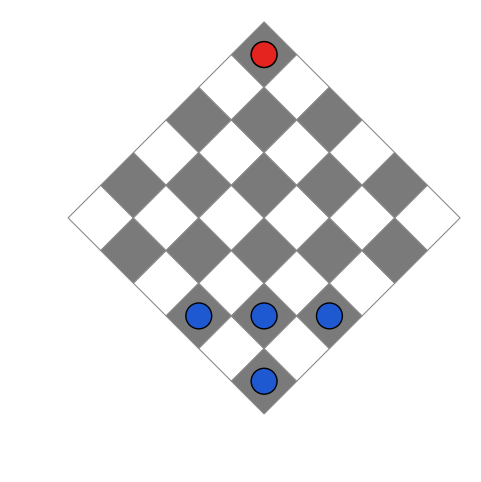

In [ ]:
board_figure, board_axis, transform = make_diamond_board_ax(figsize=(6,6), pad=2.0)
_ = render_game_state(board_axis, initial_state(), transform)
plt.show()


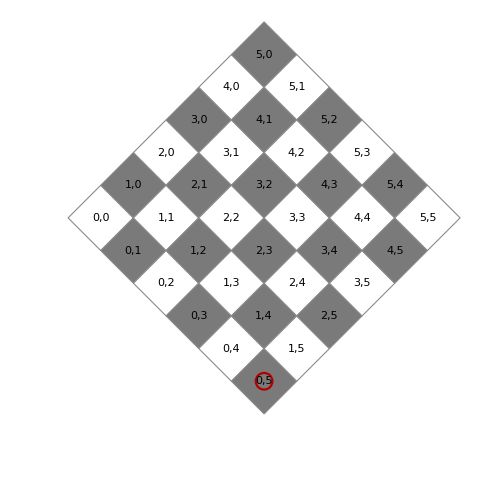

In [179]:
def show_indices():
    fig, ax, t = make_diamond_board_ax(figsize=(6,6), pad=2.0)
    for r in range(BOARD_N):
        for c in range(BOARD_N):
            x, y = _rc_to_xy(r, c, center=True)
            txt = ax.text(x, y, f"{r},{c}", ha="center", va="center", fontsize=8)
            txt.set_transform(t)
    plt.show()

show_indices()